### Import Libraries



In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


### Connect to Drive



In [2]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read DataSet

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [4]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


### Classes

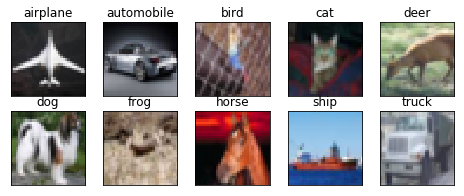

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Functions for Post Training Analysis 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Preparing Data

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

### Import Cutout

In [10]:
!wget "https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py"
from random_eraser import get_random_eraser

--2019-07-20 13:15:27--  https://raw.githubusercontent.com/yu4u/cutout-random-erasing/master/random_eraser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘random_eraser.py.2’

random_eraser.py.2  100%[===================>]     888  --.-KB/s    in 0s      

2019-07-20 13:15:27 (166 MB/s) - ‘random_eraser.py.2’ saved [888/888]



### Define Model

In [11]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))


W0720 13:15:29.305233 140107371919232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0720 13:15:29.322408 140107371919232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 13:15:29.325444 140107371919232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 13:15:29.356571 140107371919232 deprecation_wrapper.py

### Model Summary

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Compile Model

In [13]:
# Compile the model
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


W0720 13:15:30.811304 140107371919232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Image Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, featurewise_center=True, featurewise_std_normalization=True,
                             horizontal_flip=False, preprocessing_function=get_random_eraser(s_l=0.25, s_h=0.25,v_l=0, v_h=1))

### LR Finder

In [15]:
!wget "https://raw.githubusercontent.com/surmenok/keras_lr_finder/master/keras_lr_finder/lr_finder.py"
from lr_finder import LRFinder

--2019-07-20 13:15:32--  https://raw.githubusercontent.com/surmenok/keras_lr_finder/master/keras_lr_finder/lr_finder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5547 (5.4K) [text/plain]
Saving to: ‘lr_finder.py.1’

lr_finder.py.1      100%[===================>]   5.42K  --.-KB/s    in 0s      

2019-07-20 13:15:32 (97.9 MB/s) - ‘lr_finder.py.1’ saved [5547/5547]



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
W0720 13:15:36.533168 140107371919232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
50000/50000 [==============================] - 14s 277us/step - loss: 2.5968 - acc: 0.1767
Epoch 2/5
50000/50000 [==============================] - 10s 192us/step - loss: 1.9185 - acc: 0.3070
Epoch 3/5
50000/50000 [==============================] - 10s 193us/step - loss: 1.6403 - acc: 0.4198
Epoch 4/5
50000/50000 [==============================] - 10s 195us/step - loss: 1.4234 - acc: 0.5027
Epoch 5/5
50000/50000 [==============================] - 10s 196us/step - loss: 1.4226 - acc: 0.5169


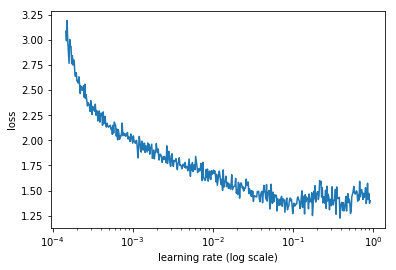

In [16]:
# model is a Keras model
lr_finder = LRFinder(model)

iterator = datagen.flow(train_features, train_labels, batch_size=len(train_features), shuffle=False)
trainX, trainy = iterator.next()

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(trainX, trainy, start_lr=0.0001, end_lr=1, batch_size=512, epochs=5)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

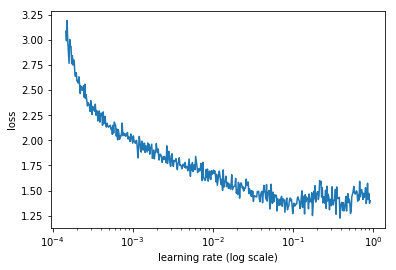

In [17]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

### Compile with best starting learning rate

In [0]:
# Compile the model
model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


### Model Training

mkdir: cannot create directory ‘Assignment11’: File exists


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by call


Epoch 00001: val_acc improved from -inf to 0.27450, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00002: val_acc improved from 0.27450 to 0.49720, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00003: val_acc improved from 0.49720 to 0.60260, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00004: val_acc improved from 0.60260 to 0.66110, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00005: val_acc improved from 0.66110 to 0.67010, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00006: val_acc improved from 0.67010 to 0.71020, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00007: val_acc improved from 0.71020 to 0.72630, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00008: val_acc improved from 0.72630 to 0.74550, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00009: val_acc improved from 0.74550 to 0.74950, saving model to Assignment11//maxAccuracy.hdf5

Epoch 00010: val_acc did not improve from 0.74950

Epoch 00011: val_acc imp

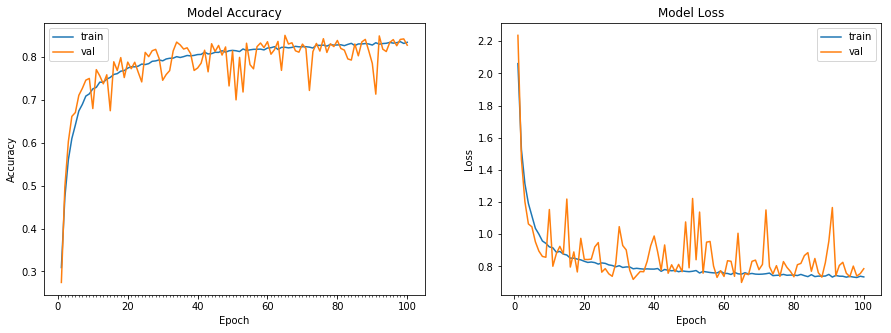

Accuracy on test data is: 82.69


In [19]:
from keras.callbacks import ModelCheckpoint
!mkdir "Assignment11"
filepath="Assignment11//maxAccuracy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=0, callbacks=callbacks_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#### Save Model

In [0]:
model.load_weights('./Assignment11//maxAccuracy.hdf5')
model.save('./drive/My Drive/EVA/11a_cutout_CIFAR10-65-0.85.hdf5.h5')

#### Evaluate Model

In [24]:
model.load_weights('./drive/My Drive/EVA/11a_cutout_CIFAR10-65-0.85.hdf5.h5')
model.evaluate(test_features, test_labels)

10000/10000 [==============================] - 1s 137us/step


[0.7007329928874969, 0.8498]

### Misclassified Images

In [25]:
import pandas as pd

val_iterator= datagen.flow(test_features, test_labels, len(test_features), shuffle=False)
x_val, y_val = next(val_iterator)
Y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
Y_pred = y_pred.argmax(axis=1)
d = {'pred': Y_pred, 'true': Y_val} #axis=1!important!
df=pd.DataFrame(data=d)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
MisIndex = df[(df.pred != df.true)].index

### GradCam

In [0]:
def GradCam(testImage):
  img = testImage
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("activation_6")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(grads.shape[-1]):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = testImage
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return superimposed_img

### Gallary for 25 misclassified Image

In [0]:
import cv2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import sys
% matplotlib inline
import matplotlib.pyplot as plt

In [0]:
imageIndex=MisIndex[0:25]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6

(-0.5, 31.5, 31.5, -0.5)

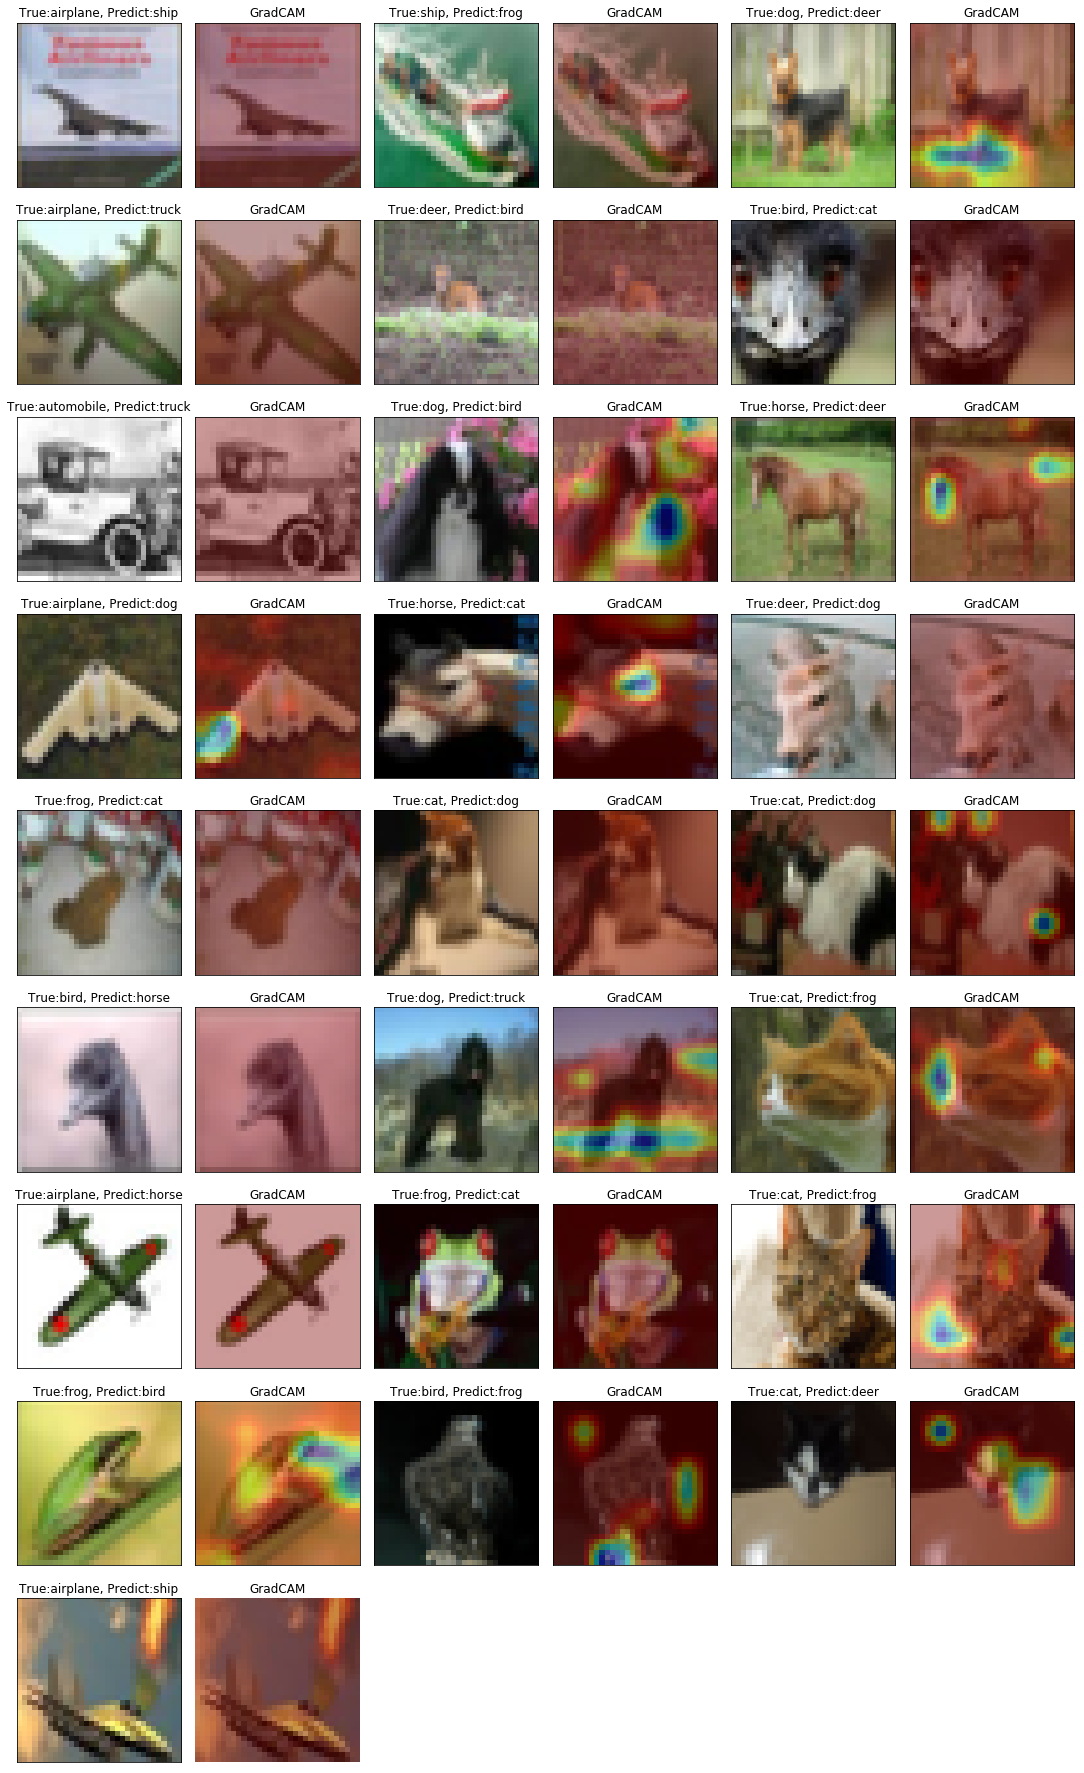

In [36]:
fig = plt.figure(figsize=(32,32))

for i in range(25):
  
  img = test_features[imageIndex[i]]
  ax = fig.add_subplot(9, 6, 2*i+1, xticks=[], yticks=[])
  ax.set_title('True:%s, Predict:%s' %(class_names[df.iloc[MisIndex[i]].true], class_names[df.iloc[MisIndex[i]].pred]))
  plt.imshow(img)
  ax = fig.add_subplot(9, 6, 2*i+2, xticks=[], yticks=[])
  ax.set_title("GradCAM")
  superimposed=GradCam(img)
  plt.imshow(superimposed)
  plt.subplots_adjust(wspace=-0.8)
plt.axis('off')